In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp

ds_name = '04272021'
ds_folder = f'../data/{ds_name}'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/04272021\cluster_dynamics.csv
../data/04272021\duplicate_trees.csv
../data/04272021\edges.csv
../data/04272021\err_nodes.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
%matplotlib inline

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [3]:
#Import the files
node_df = pd.read_csv(f'{ds_folder}/cluster_dynamics.csv')
edge_df = pd.read_csv(f'{ds_folder}/edges.csv')

In [4]:
print('Shape of node data is', node_df.shape)
print ('Shape of edge data is', edge_df.shape)

Shape of node data is (3990589, 20)
Shape of edge data is (3948750, 5)


### Preprocessing-1: node data
    1-1. impute missing dynamic_model value to 0(not used in prediction)
    1-2. remove error node(node with mismatching features)
    1-3. check other missing features

In [5]:
#check the train data
node_df.tail()

# so there are around 20 features here in this dataset (But 02172021 only has 19 features)

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node
3990584,9,C,static,NaN,c4,0.604319,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3990585,9,D,static,NaN,c2,0.886956,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3990586,9,E,static,NaN,c5,0.802538,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3990587,9,F,growth,0.0403140430180747,c6,0.883474,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3990588,9,G,decay,0.219002927451965,c3,0.653183,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#impute missing data of dynamic model to 0 (TBD)
impute_node = np.where(pd.isna(node_df['dynamic_model'])==True)
node_df.loc[(impute_node[0]),'dynamic_model']=0

#drop non-node data points
err_node_df = node_df[pd.isna(node_df['node'])==True]
err_node_df.to_csv(f"{ds_folder}/err_nodes.csv")

err_node_df

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node
0,1002,Background,static,NaN,Background,0.048432,542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1002,A,static,NaN,c1,0.344611,157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1002,C,static,NaN,c2,0.959899,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1002,D,static,NaN,c5,0.914490,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1002,E,static,NaN,c6,0.986697,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3990584,9,C,static,NaN,c4,0.604319,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3990585,9,D,static,NaN,c2,0.886956,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3990586,9,E,static,NaN,c5,0.802538,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3990587,9,F,growth,0.0403140430180747,c6,0.883474,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
err_treeids = err_node_df["cluster_id"].values
print('Number of error node is', len(err_treeids))
err_treeids = set(err_treeids)

print(f'Number of unique treeID for error nodes: {len(err_treeids)}')

Number of error node is 39032
Number of unique treeID for error nodes: 5043


In [8]:
# Nodes after removing the error nodes

#drop non-node data points
drop_node = np.where(pd.isna(node_df['node'])==True)
node_df = node_df.drop(drop_node[0])

print('Number of dropped node is', len(drop_node[0]))
node_df.tail()

Number of dropped node is 39032


,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node
3990577,c6,99,C,static,0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,541.0
3990578,c6,99,C,static,0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,941.0
3990579,c6,99,C,static,0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,939.0
3990580,c6,99,C,static,0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,329.0
3990581,c6,99,C,static,0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,542.0


In [9]:
treeids = set(node_df["sim"].values)
print(f'Number of unique treeID for norm nodes: {len(treeids)}')

Number of unique treeID for norm nodes: 2315


In [10]:
intersec_treeids = err_treeids.intersection(treeids)
print(f'Overlapped treeIDs between norm and error: {len(intersec_treeids)}')

Overlapped treeIDs between norm and error: 658


In [11]:
node_df["dynamic_model"].unique()

array([0, '0.559118093533358', '0.0134283743394147', ...,
       '0.441388359739659', '0.506102147526221', '0.0179045482088513'],
      dtype=object)

In [12]:
# convert the data type of sim and dynamic model
node_df['sim'] = pd.to_numeric(node_df['sim'])
node_df['dynamic_model'] = pd.to_numeric(node_df['dynamic_model'])

In [13]:
# change the dynamic of background nodes to bg
impute_node = np.where(node_df['state']=='Background')
node_df = node_df.reset_index(drop=True)
node_df.loc[(impute_node[0]),'dynamic']='bg'

In [14]:
node_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node
0,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,7.0
1,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,132.0
2,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,513.0
3,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,230.0
4,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,255.0


In [15]:
node_df.tail()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node
3951552,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,541.0
3951553,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,941.0
3951554,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,939.0
3951555,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,329.0
3951556,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,542.0


In [16]:
#information about the node data set
node_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3951557 entries, 0 to 3951556
Data columns (total 20 columns):
 #   Column                Dtype  
---  ------                -----  
 0   cluster_id            object 
 1   sim                   int64  
 2   state                 object 
 3   dynamic               object 
 4   dynamic_model         float64
 5   v_sampling_fraction   float64
 6   v_cluster_size        int64  
 7   v_timespan            float64
 8   gamma                 float64
 9   oster                 float64
 10  birth_rate            float64
 11  PD                    float64
 12  R0                    float64
 13  abs_growth_rate       float64
 14  fraction_time_growth  float64
 15  r_max                 float64
 16  ltt_shape             object 
 17  cherries              float64
 18  BLD                   float64
 19  node                  float64
dtypes: float64(14), int64(2), object(4)
memory usage: 603.0+ MB


In [17]:
node_df.describe()

,sim,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,cherries,BLD,node
count,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06
mean,2.052526e+03,5.311402e-03,1.437753e-01,5.557365e+02,8.332570e+01,inf,8.333262e+01,4.935660e+02,1.359841e+04,-2.886865e+03,6.346556e+09,4.825717e-01,2.818265e+03,3.270833e-01,4.074069e+00,7.134104e+02
std,1.166937e+03,4.888729e-02,2.268431e-01,2.103211e+02,2.621830e+01,NaN,2.620902e+01,9.887452e+04,5.538338e+03,2.851270e+05,1.294364e+12,3.067652e-01,9.490723e+04,2.338149e-02,3.874192e+00,4.228524e+02
min,1.000000e+00,-2.744005e-01,4.088723e-02,5.000000e+00,3.000000e+00,-6.179215e+03,3.090909e+00,2.314829e-02,5.000000e+00,-1.448334e+08,1.334146e-03,0.000000e+00,-5.639996e+07,1.000000e-01,-7.200000e+01,1.000000e+00
25%,1.052000e+03,0.000000e+00,5.531411e-02,5.530000e+02,8.300000e+01,-1.719504e+01,8.300416e+01,3.418333e-02,1.387000e+04,-7.487323e-01,8.764582e+01,2.173913e-01,2.719098e+03,3.222061e-01,4.000000e+00,3.520000e+02
50%,2.032000e+03,0.000000e+00,6.051423e-02,6.080000e+02,9.000000e+01,-1.623615e+01,9.000370e+01,3.570311e-02,1.537000e+04,9.054323e-01,1.174670e+02,4.791667e-01,3.762441e+03,3.288889e-01,5.000000e+00,7.040000e+02
75%,3.058000e+03,0.000000e+00,6.859314e-02,6.640000e+02,9.700000e+01,-1.444427e+01,9.700333e+01,3.868524e-02,1.656500e+04,2.204702e+00,1.477896e+02,7.454545e-01,4.773502e+03,3.346995e-01,6.000000e+00,1.056000e+03
max,4.115000e+03,1.012940e+00,9.999999e-01,1.188000e+03,1.540000e+02,inf,1.540019e+02,3.503330e+07,2.462700e+04,8.031474e+00,2.881675e+14,1.000000e+00,4.215281e+04,5.000000e-01,1.500000e+01,2.546000e+03


In [18]:
# import pandas_profiling
# node_df.profile_report() 

In [19]:
#check for the missing values in the node data
node_df.isnull().sum()

cluster_id              0
sim                     0
state                   0
dynamic                 0
dynamic_model           0
v_sampling_fraction     0
v_cluster_size          0
v_timespan              0
gamma                   0
oster                   0
birth_rate              0
PD                      0
R0                      0
abs_growth_rate         0
fraction_time_growth    0
r_max                   0
ltt_shape               0
cherries                0
BLD                     0
node                    0
dtype: int64

In [20]:
# Check which variables have missing values

node_columns_with_missing_values = node_df.columns[node_df.isnull().any()]
node_df[node_columns_with_missing_values].isnull().sum()

Series([], dtype: float64)

In [21]:
# total missing values in the entire df
node_df.isnull().sum().sum()

0

In [22]:
missing_series = node_df.isnull().sum() 
missing_series.where(missing_series>1000)
missing_series.loc[missing_series>1000]/node_df.shape[0] # to locate the missing values that are more than 1000

Series([], dtype: float64)

<AxesSubplot:>

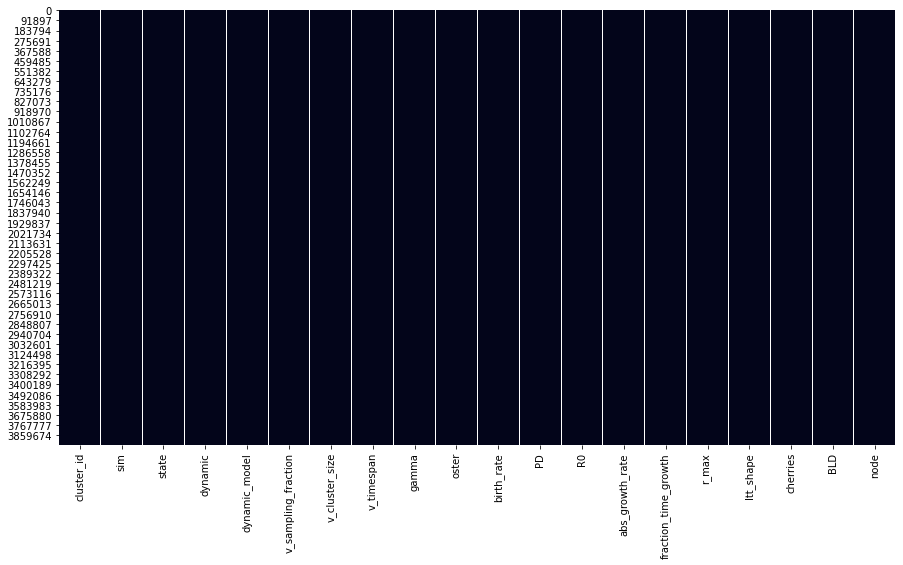

In [23]:
# Now using heatmaps
plt.figure(figsize=(15,8))
sns.heatmap(node_df.isnull(), cbar=False)
# FRom this heatmap too it is evident that the above 2 mentioned vars have more missing values

<AxesSubplot:>

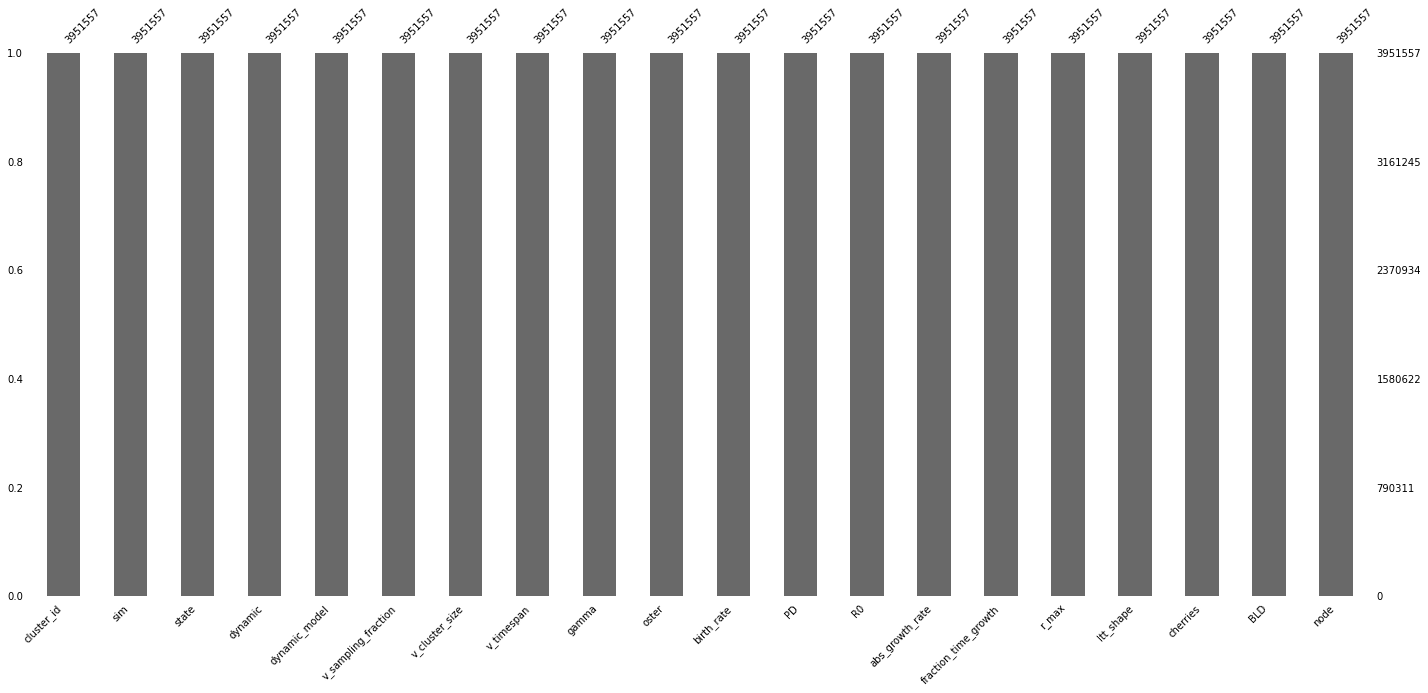

In [24]:
# Next is to use the missingno library to analyze the missing values
import missingno as msno 

msno.bar(node_df,labels=True,fontsize=10) 

D:\Downloads\lib\site-packages\seaborn\matrix.py:311: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
D:\Downloads\lib\site-packages\seaborn\matrix.py:311: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


<AxesSubplot:>

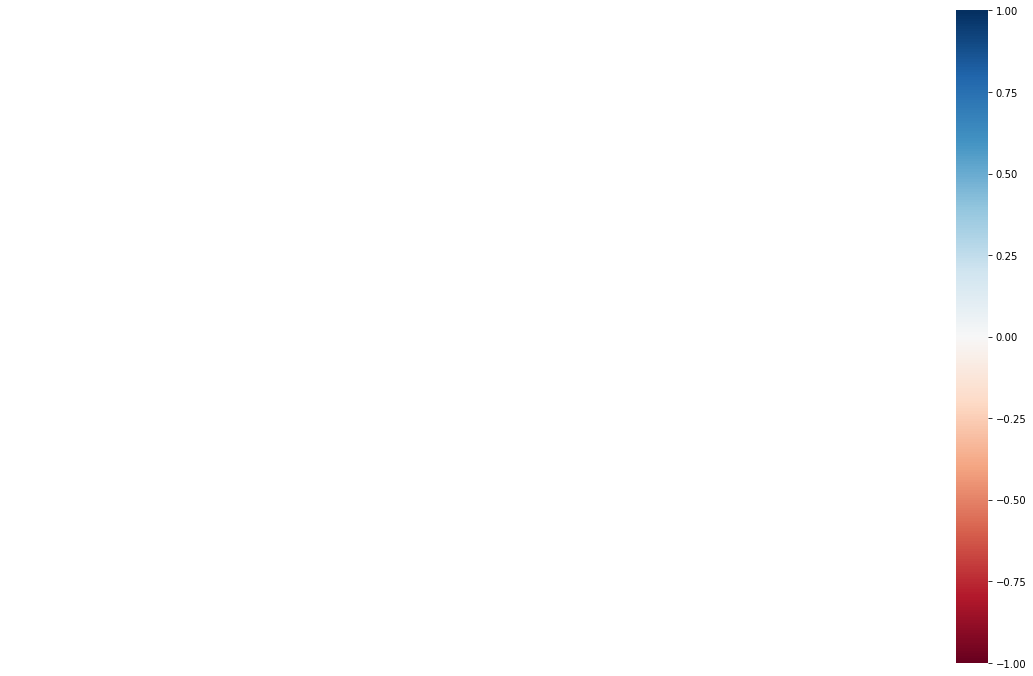

In [25]:
# The missingno correlation heatmap measures nullity correlation: 
# how strongly the presence or absence of one variable affects the presence of another:
msno.heatmap(node_df,labels=True) 

# Entries marked <1 or >-1 have a correlation that is close to being exactingly negative or positive, but is still not quite perfectly so
# Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does)

### Preprocessing-2: edge data

In [26]:
edge_df.tail()

,from,to,weight1,weight2,sim
3948745,1180,136,3,0.002905,99
3948746,1180,317,7,0.006492,99
3948747,1179,1181,8,0.006875,99
3948748,1181,98,15,0.014371,99
3948749,1181,605,20,0.017163,99


In [27]:
edge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3948750 entries, 0 to 3948749
Data columns (total 5 columns):
 #   Column   Dtype  
---  ------   -----  
 0   from     int64  
 1   to       int64  
 2   weight1  int64  
 3   weight2  float64
 4   sim      int64  
dtypes: float64(1), int64(4)
memory usage: 150.6 MB


### Count number of trees

In [28]:
node_tree_ids = node_df['sim'].unique()
edge_tree_ids = edge_df['sim'].unique()
assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(node_tree_ids)
tree_ids = node_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 2315


In [29]:
print('Shape of node data is', node_df.shape)
print('Shape of edge data is', edge_df.shape)

Shape of node data is (3951557, 20)
Shape of edge data is (3948750, 5)


### Extra: Error check duplicate number of nodes and edges on a tree
    Number of nodes for one tree should equal to number of edges plus 1. 

In [30]:
err_dic = {}
err_treeids = []
for one_tree_id in node_tree_ids:
    onetree_node_df = node_df[node_df['sim'] == one_tree_id] 
    uni_node_sample = onetree_node_df.drop_duplicates()
    uni_node = onetree_node_df.drop_duplicates('node')
    onetree_edge_df = edge_df[edge_df['sim'] == one_tree_id]
    uni_edge_sample = onetree_edge_df.drop_duplicates()
    uni_edge = onetree_edge_df.drop_duplicates(['from','to'])
    if len(uni_node) == len(uni_edge)+1:
        continue
    else:
        err_dic[one_tree_id] = [len(onetree_node_df),len(uni_node_sample),len(uni_node),len(onetree_edge_df),len(uni_edge_sample),len(uni_edge)]
        err_treeids.append(one_tree_id)
        node_df = node_df.drop(node_df[node_df['sim']==one_tree_id].index)
        edge_df = edge_df.drop(edge_df[edge_df['sim']==one_tree_id].index)

In [31]:
print('Shape of node data is', node_df.shape)
print('Shape of edge data is', edge_df.shape)

Shape of node data is (2554194, 20)
Shape of edge data is (2552371, 5)


In [32]:
node_tree_ids = node_df['sim'].unique()
edge_tree_ids = edge_df['sim'].unique()
assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(node_tree_ids)
tree_ids = node_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 1823


### Processing-3: R0 correction
* Use the mean value of positive R0 in the **training** to replace all the negative R0 in the training and test
* Normalize the R0

In [33]:
raw_r0 = np.reshape(node_df['R0'].values, (-1, 1))

# negtive replacement
r0_neg_idx = raw_r0 <= 0
r0_pos_idx = raw_r0 > 0
avg_r0 = np.average(raw_r0[r0_pos_idx])

raw_r0[r0_neg_idx] = avg_r0

In [34]:
node_df['R0'].describe()

count    2.554194e+06
mean     1.860604e+00
std      8.875693e-01
min      7.140475e-04
25%      1.416029e+00
50%      1.860604e+00
75%      2.196953e+00
max      8.031219e+00
Name: R0, dtype: float64

In [35]:
r0_norm_col = 'new_R0'
node_df[r0_norm_col]=raw_r0
node_df[r0_norm_col].describe()

count    2.554194e+06
mean     1.860604e+00
std      8.875693e-01
min      7.140475e-04
25%      1.416029e+00
50%      1.860604e+00
75%      2.196953e+00
max      8.031219e+00
Name: new_R0, dtype: float64

In [36]:
node_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,new_R0
0,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,7.0,1.860604
1,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,132.0,1.860604
2,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,513.0,1.860604
3,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,230.0,1.860604
4,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,255.0,1.860604


In [37]:
node_df.tail()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,new_R0
3951552,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,1.860604,15.35789,0.333333,44.336628,convex,0.4,-10.5,541.0,1.860604
3951553,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,1.860604,15.35789,0.333333,44.336628,convex,0.4,-10.5,941.0,1.860604
3951554,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,1.860604,15.35789,0.333333,44.336628,convex,0.4,-10.5,939.0,1.860604
3951555,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,1.860604,15.35789,0.333333,44.336628,convex,0.4,-10.5,329.0,1.860604
3951556,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,1.860604,15.35789,0.333333,44.336628,convex,0.4,-10.5,542.0,1.860604


### Preprocessing-4: Gamma discretization
    * Quantile-based discretization function

In [38]:
gamma_cats, gamma_bins = pd.qcut(node_df['gamma'], 4, retbins=True, duplicates='drop')
gamma_cat_dict = {cat: i for i, cat in enumerate(gamma_cats.unique())}
print(gamma_bins)
print(gamma_cat_dict)

[-6179.21497392   -17.18509536   -16.21790297   -14.44892529
            inf]
{Interval(-16.218, -14.449, closed='right'): 0, Interval(-14.449, inf, closed='right'): 1, Interval(-6179.216, -17.185, closed='right'): 2, Interval(-17.185, -16.218, closed='right'): 3}


In [39]:
node_df['gamma_bin'] = gamma_cats
node_df['gamma_cat'] = node_df['gamma_bin'].replace(gamma_cat_dict, inplace=False)
print(f'Gamma cat: {node_df["gamma_cat"].unique()}')
node_df.head()

Gamma cat: [0 1 2 3]


,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,new_R0,gamma_bin,gamma_cat
0,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,7.0,1.860604,"(-16.218, -14.449]",0
1,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,132.0,1.860604,"(-16.218, -14.449]",0
2,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,513.0,1.860604,"(-16.218, -14.449]",0
3,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,230.0,1.860604,"(-16.218, -14.449]",0
4,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,255.0,1.860604,"(-16.218, -14.449]",0


### Preprocessing-5: Encode the categorical feature and label
#### Categorical features
    * ltt_shape
    * gamma (processed before)

In [40]:
# Use to record all the feature transformations
feat_dict = dict()

In [41]:
node_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,new_R0,gamma_bin,gamma_cat
0,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,7.0,1.860604,"(-16.218, -14.449]",0
1,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,132.0,1.860604,"(-16.218, -14.449]",0
2,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,513.0,1.860604,"(-16.218, -14.449]",0
3,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,230.0,1.860604,"(-16.218, -14.449]",0
4,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,255.0,1.860604,"(-16.218, -14.449]",0


In [42]:
#First of all we need to get the columns where the categorical features are present
# idea is to extract all the columns with type as object
node_df.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64'),
       CategoricalDtype(categories=[(-6179.216, -17.185], (-17.185, -16.218], (-16.218, -14.449], (-14.449, inf]],
              ordered=True)], dtype=object)

In [43]:
for types in node_df.dtypes.unique():
    print(types,len(node_df.select_dtypes(types).columns))
    print(node_df.select_dtypes(types).columns)
    print('===')

object 4
Index(['cluster_id', 'state', 'dynamic', 'ltt_shape'], dtype='object')
===
int64 3
Index(['sim', 'v_cluster_size', 'gamma_cat'], dtype='object')
===
float64 15
Index(['dynamic_model', 'v_sampling_fraction', 'v_timespan', 'gamma', 'oster',
       'birth_rate', 'PD', 'R0', 'abs_growth_rate', 'fraction_time_growth',
       'r_max', 'cherries', 'BLD', 'node', 'new_R0'],
      dtype='object')
===
category 1
Index(['gamma_bin'], dtype='object')
===


In [44]:
# Category the ltt_shape

# node_df = node_df.astype({'ltt_shape': 'category'}, copy=False)
node_df["ltt_shape"] = node_df["ltt_shape"].astype('category')
node_df["ltt_shape_cat"] = node_df["ltt_shape"].cat.codes
feat_dict['ltt_shape'] = dict(enumerate(node_df['ltt_shape'].cat.categories))
      
print(feat_dict)
node_df.head()

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}}


,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,new_R0,gamma_bin,gamma_cat,ltt_shape_cat
0,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,7.0,1.860604,"(-16.218, -14.449]",0,3
1,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,132.0,1.860604,"(-16.218, -14.449]",0,3
2,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,513.0,1.860604,"(-16.218, -14.449]",0,3
3,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,230.0,1.860604,"(-16.218, -14.449]",0,3
4,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,255.0,1.860604,"(-16.218, -14.449]",0,3


In [45]:
# Record the cat_dict for gamma, reverse the previous the dict
for feat_name, cat_dict in zip(['gamma'], [gamma_cat_dict]):
    tmp_dict = {}
    for k, v in cat_dict.items():
        tmp_dict[v] = f'{k.left, k.right, k.closed}'
    feat_dict[feat_name] = tmp_dict
print(feat_dict)

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'gamma': {0: "(-16.218, -14.449, 'right')", 1: "(-14.449, inf, 'right')", 2: "(-6179.216, -17.185, 'right')", 3: "(-17.185, -16.218, 'right')"}}


#### Categorical label
    * Convert the dynamic column to the int value
    * 0 for background

In [46]:
node_df["dynamic"] = node_df["dynamic"].astype('category')
node_df["dynamic_cat"] = node_df["dynamic"].cat.codes

In [57]:
node_df

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,new_R0,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat
0,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.520410,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,7.0,1.860604,"(-16.218, -14.449]",0,3,0
1,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.520410,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,132.0,1.860604,"(-16.218, -14.449]",0,3,0
2,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.520410,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,513.0,1.860604,"(-16.218, -14.449]",0,3,0
3,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.520410,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,230.0,1.860604,"(-16.218, -14.449]",0,3,0
4,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.520410,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,255.0,1.860604,"(-16.218, -14.449]",0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3951552,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,1.860604,15.35789,0.333333,44.336628,convex,0.400000,-10.5,541.0,1.860604,"(-14.449, inf]",1,2,3
3951553,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,1.860604,15.35789,0.333333,44.336628,convex,0.400000,-10.5,941.0,1.860604,"(-14.449, inf]",1,2,3
3951554,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,1.860604,15.35789,0.333333,44.336628,convex,0.400000,-10.5,939.0,1.860604,"(-14.449, inf]",1,2,3
3951555,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,1.860604,15.35789,0.333333,44.336628,convex,0.400000,-10.5,329.0,1.860604,"(-14.449, inf]",1,2,3


In [50]:
node_df = node_df.reset_index(drop=True)
impute_node = np.where(node_df['state']=='Background')
node_df.loc[(impute_node[0]),'dynamic_cat']=3
impute_node = np.where(node_df['dynamic']=='static')
node_df.loc[(impute_node[0]),'dynamic_cat']=0
feat_dict['dynamic'] = dict(enumerate(node_df['dynamic'].cat.categories))
feat_dict['dynamic'][0] = 'static'
feat_dict['dynamic'][3] = 'bg'
print(feat_dict)

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'gamma': {0: "(-16.218, -14.449, 'right')", 1: "(-14.449, inf, 'right')", 2: "(-6179.216, -17.185, 'right')", 3: "(-17.185, -16.218, 'right')"}, 'dynamic': {0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}}


In [51]:
node_df.tail()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,new_R0,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat
2554189,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,1.860604,15.35789,0.333333,44.336628,convex,0.4,-10.5,541.0,1.860604,"(-14.449, inf]",1,2,0
2554190,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,1.860604,15.35789,0.333333,44.336628,convex,0.4,-10.5,941.0,1.860604,"(-14.449, inf]",1,2,0
2554191,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,1.860604,15.35789,0.333333,44.336628,convex,0.4,-10.5,939.0,1.860604,"(-14.449, inf]",1,2,0
2554192,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,1.860604,15.35789,0.333333,44.336628,convex,0.4,-10.5,329.0,1.860604,"(-14.449, inf]",1,2,0
2554193,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,1.860604,15.35789,0.333333,44.336628,convex,0.4,-10.5,542.0,1.860604,"(-14.449, inf]",1,2,0


### Split the nodes into background and non-background

In [52]:
background_df = node_df[node_df['cluster_id']=='Background']
background_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,new_R0,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat
0,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,7.0,1.860604,"(-16.218, -14.449]",0,3,3
1,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,132.0,1.860604,"(-16.218, -14.449]",0,3,3
2,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,513.0,1.860604,"(-16.218, -14.449]",0,3,3
3,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,230.0,1.860604,"(-16.218, -14.449]",0,3,3
4,Background,1003,Background,bg,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,1.860604,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,255.0,1.860604,"(-16.218, -14.449]",0,3,3


In [53]:
node_df = node_df[node_df['cluster_id']!='Background']
node_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,new_R0,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat
997,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1017.0,3.599752,"(-14.449, inf]",1,0,0
998,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1018.0,3.599752,"(-14.449, inf]",1,0,0
999,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1016.0,3.599752,"(-14.449, inf]",1,0,0
1000,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,31.0,3.599752,"(-14.449, inf]",1,0,0
1001,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,401.0,3.599752,"(-14.449, inf]",1,0,0


### Analysis-1 Correlation 
#### 1-1. The relationship between categorical features and label

In [54]:
from sklearn.feature_selection import chi2, mutual_info_classif

cat_feat_cols = ['ltt_shape_cat', 'gamma_cat']
chi2_sts, p_vals = chi2(node_df[cat_feat_cols], node_df['dynamic_cat'])
mis = mutual_info_classif(node_df[cat_feat_cols], node_df['dynamic_cat'])

for cat, chi2, p_val, mi in zip(cat_feat_cols, chi2_sts, p_vals, mis):
    degree_freedom = (len(node_df['dynamic_cat'].unique()) - 1) * (len(node_df[cat].unique())-1)
    print(f'{cat}: \n  df: {degree_freedom}, chi2: {chi2}, p_vals: {p_val}\n  MI: {mi}')

ltt_shape_cat: 
  df: 6, chi2: 2822.6762401697497, p_vals: 0.0
  MI: 0.027004338224257296
gamma_cat: 
  df: 6, chi2: 3.4084149942148074, p_vals: 0.1819164984143462
  MI: 0.05801723605052711


### Analysis-1
#### 1-2 The relationship between numerical features and label(added BLD and dynamic model)

In [55]:
num_feat_cols = ["v_sampling_fraction", "v_cluster_size", "v_timespan", "oster", "birth_rate", "PD",
                 "abs_growth_rate", "fraction_time_growth", "r_max","cherries","BLD","new_R0"]

label_col = ["dynamic_cat"]
aly_col = num_feat_cols + cat_feat_cols + label_col
print(aly_col)

aly_df = node_df[aly_col]
print(aly_df.shape, f"num_feat: {len(num_feat_cols)}, cat_feat: {len(cat_feat_cols)}, label: {len(label_col)}")

['v_sampling_fraction', 'v_cluster_size', 'v_timespan', 'oster', 'birth_rate', 'PD', 'abs_growth_rate', 'fraction_time_growth', 'r_max', 'cherries', 'BLD', 'new_R0', 'ltt_shape_cat', 'gamma_cat', 'dynamic_cat']
(350115, 15) num_feat: 12, cat_feat: 2, label: 1


#### 1-2-1 Pearson R

In [56]:
# Compute pairwise correlation of columns (pearson R: standard correlation coefficient)
aly_df.corr()

,v_sampling_fraction,v_cluster_size,v_timespan,oster,birth_rate,PD,abs_growth_rate,fraction_time_growth,r_max,cherries,BLD,new_R0,ltt_shape_cat,gamma_cat,dynamic_cat
v_sampling_fraction,1.000000,-0.584132,-0.271682,-0.271868,0.011050,-0.387130,0.005458,0.043293,-0.004153,-0.055257,-0.101084,-0.012242,0.030420,0.019599,0.027568
v_cluster_size,-0.584132,1.000000,0.564551,0.564747,-0.016968,0.764511,-0.006461,0.015427,0.010494,0.046138,0.195216,0.045102,-0.146785,0.004982,-0.156796
v_timespan,-0.271682,0.564551,1.000000,0.999999,-0.033539,0.876861,-0.005602,0.127512,0.025956,0.033761,0.409931,0.013461,-0.209644,0.073582,-0.359239
oster,-0.271868,0.564747,0.999999,1.000000,-0.033510,0.876965,-0.005586,0.127331,0.025796,0.033644,0.409455,0.013500,-0.209483,0.073584,-0.359255
birth_rate,0.011050,-0.016968,-0.033539,-0.033510,1.000000,-0.025098,-0.000269,-0.010159,0.000464,0.002406,-0.062583,-0.017669,0.011224,-0.003921,0.021860
PD,-0.387130,0.764511,0.876861,0.876965,-0.025098,1.000000,-0.008673,0.120763,0.018162,0.053166,0.374747,0.018434,-0.267698,0.046212,-0.313100
abs_growth_rate,0.005458,-0.006461,-0.005602,-0.005586,-0.000269,-0.008673,1.000000,-0.013097,0.000188,-0.021143,-0.029449,-0.000143,0.003845,-0.001136,-0.004675
fraction_time_growth,0.043293,0.015427,0.127512,0.127331,-0.010159,0.120763,-0.013097,1.000000,0.022818,-0.006456,0.028526,0.150370,-0.075907,0.000787,-0.070511
r_max,-0.004153,0.010494,0.025956,0.025796,0.000464,0.018162,0.000188,0.022818,1.000000,-0.014650,0.023250,0.000261,-0.006716,0.001985,-0.003761
cherries,-0.055257,0.046138,0.033761,0.033644,0.002406,0.053166,-0.021143,-0.006456,-0.014650,1.000000,0.048237,-0.030668,-0.026345,-0.020157,-0.007424


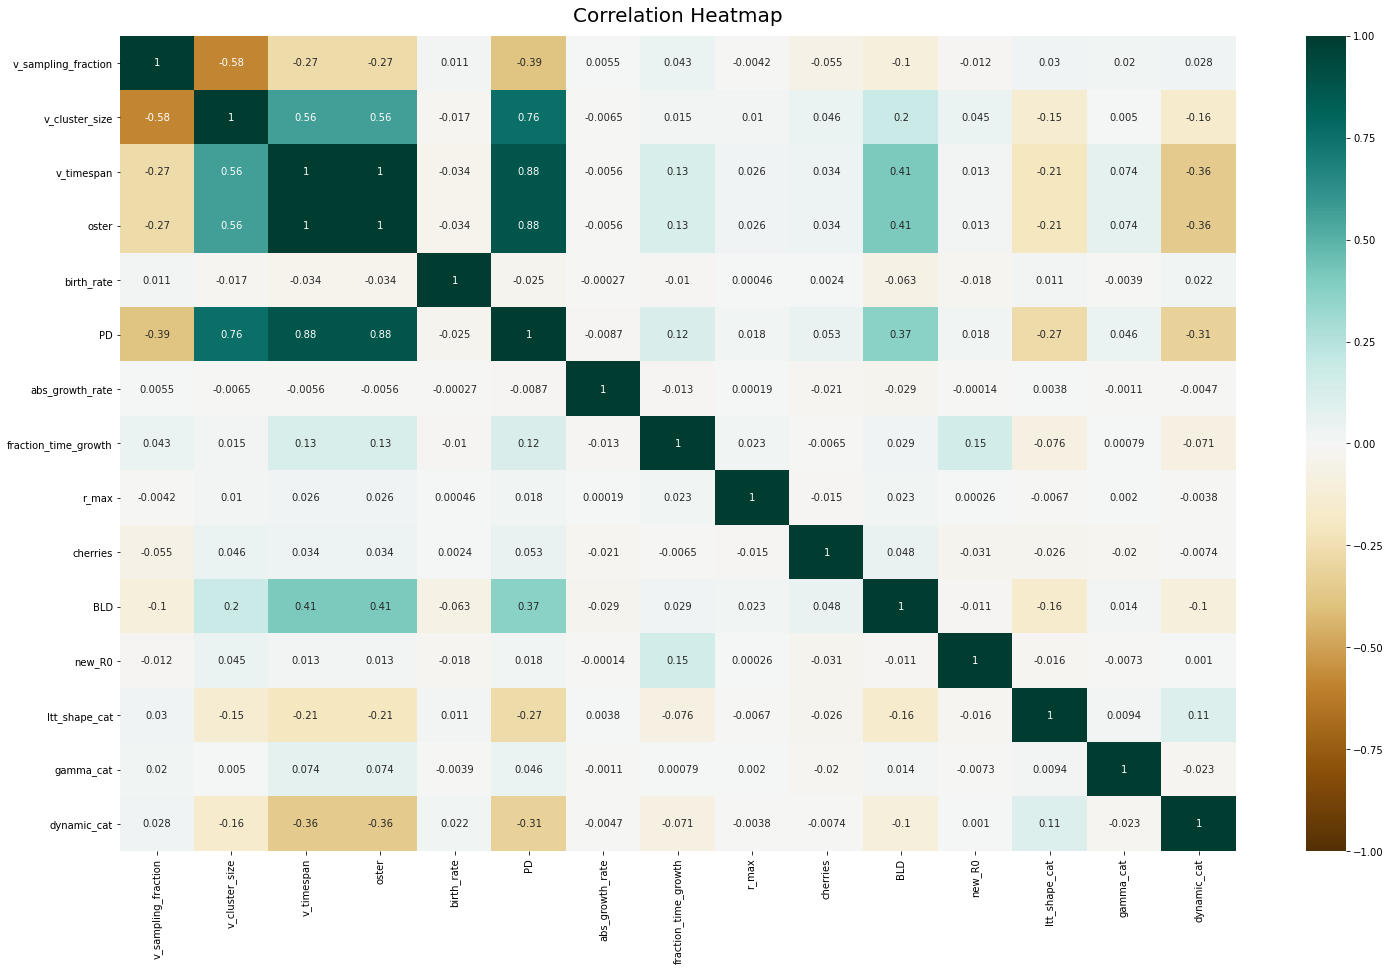

In [57]:
# Pearson Correlation Matrix

# Increase the size of the heatmap.
plt.figure(figsize=(25, 15))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(aly_df.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=14);

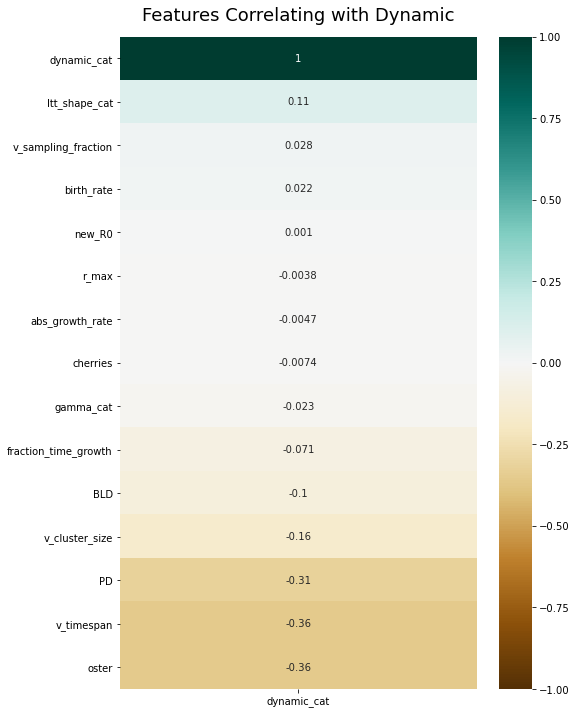

In [58]:
#check the features that are highly correlated to the output variable
plt.figure(figsize=(8, 12))
heatmap_outputvar = sns.heatmap(aly_df.corr()[['dynamic_cat']].sort_values(by='dynamic_cat', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap_outputvar.set_title('Features Correlating with Dynamic', fontdict={'fontsize':18}, pad=16);

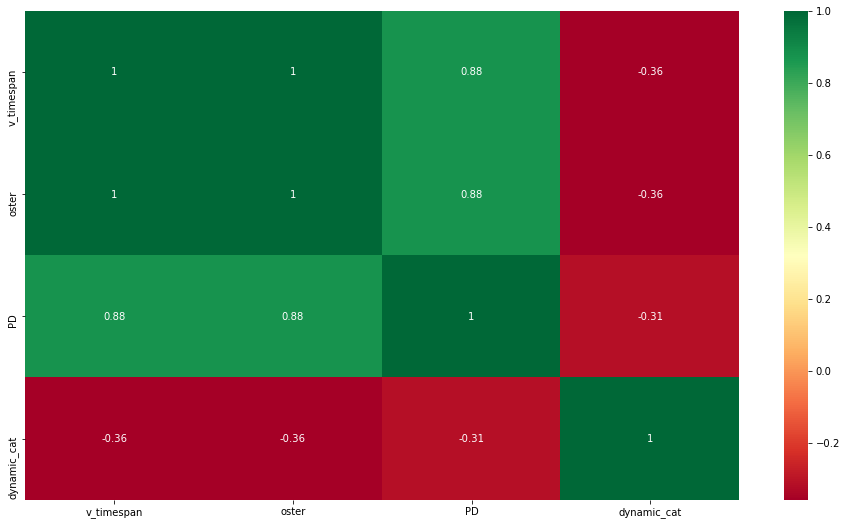

In [59]:
# most correlated features

corrmat = aly_df.corr()
top_corr_features = corrmat.index[abs(corrmat['dynamic_cat'])>0.3]
plt.figure(figsize=(16,9))
g = sns.heatmap(aly_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

#### 1-2-2 Spearman correlation

In [60]:
# Compute pairwise correlation of columns (Spearman rank correlation, non-linear)
aly_df.corr("spearman")

,v_sampling_fraction,v_cluster_size,v_timespan,oster,birth_rate,PD,abs_growth_rate,fraction_time_growth,r_max,cherries,BLD,new_R0,ltt_shape_cat,gamma_cat,dynamic_cat
v_sampling_fraction,1.000000,-0.487363,-0.229585,-0.234726,0.344875,-0.266008,-0.193034,0.030054,-0.219725,-0.077171,-0.223185,-0.011797,0.024235,0.012370,0.023923
v_cluster_size,-0.487363,1.000000,0.669401,0.670241,-0.542327,0.725699,0.365158,0.105397,0.604795,0.025697,0.319907,0.014881,-0.188715,0.046587,-0.242542
v_timespan,-0.229585,0.669401,1.000000,0.999683,-0.768835,0.931125,0.384543,0.173672,0.816917,0.006139,0.373415,0.006247,-0.226652,0.076563,-0.371911
oster,-0.234726,0.670241,0.999683,1.000000,-0.781844,0.931584,0.396603,0.167952,0.819813,0.008402,0.382971,0.007173,-0.227583,0.076561,-0.371348
birth_rate,0.344875,-0.542327,-0.768835,-0.781844,1.000000,-0.715636,-0.605498,0.024633,-0.724931,-0.077669,-0.512524,-0.024311,0.154687,-0.049924,0.258480
PD,-0.266008,0.725699,0.931125,0.931584,-0.715636,1.000000,0.454418,0.188048,0.824260,0.030501,0.467108,0.000796,-0.304410,0.069270,-0.351279
abs_growth_rate,-0.193034,0.365158,0.384543,0.396603,-0.605498,0.454418,1.000000,-0.195326,0.622379,0.053293,0.367977,0.075027,-0.098326,0.033692,-0.114289
fraction_time_growth,0.030054,0.105397,0.173672,0.167952,0.024633,0.188048,-0.195326,1.000000,0.190019,-0.021635,-0.012294,0.119470,-0.090888,0.003443,-0.084826
r_max,-0.219725,0.604795,0.816917,0.819813,-0.724931,0.824260,0.622379,0.190019,1.000000,0.031388,0.374452,0.052047,-0.217365,0.070699,-0.276734
cherries,-0.077171,0.025697,0.006139,0.008402,-0.077669,0.030501,0.053293,-0.021635,0.031388,1.000000,0.070994,-0.027327,-0.023575,-0.027133,0.009405


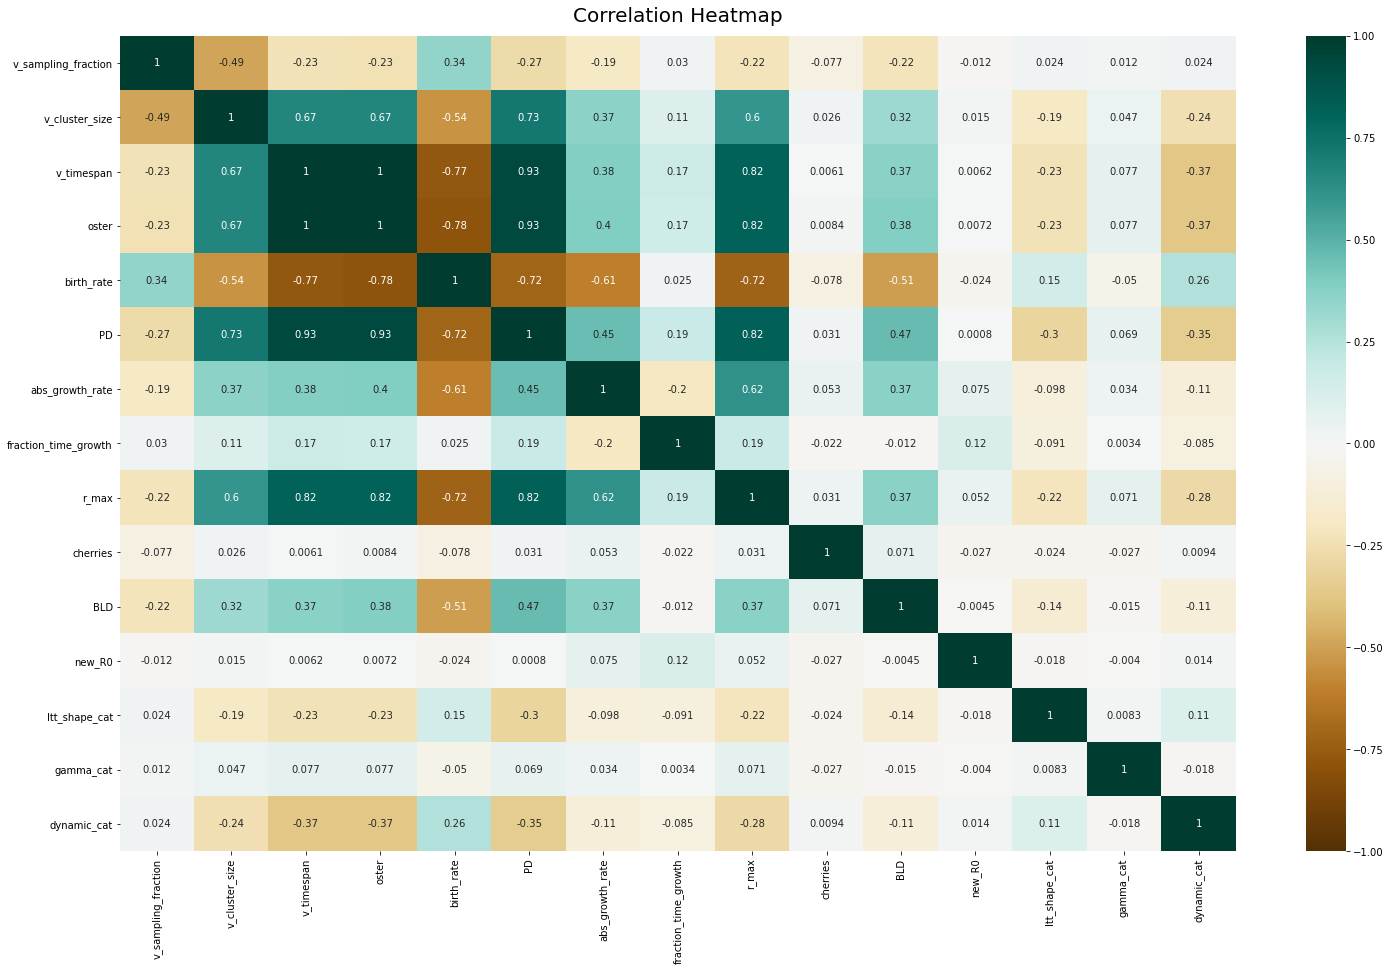

In [61]:
# Correlation Matrix

# Increase the size of the heatmap.
plt.figure(figsize=(25, 15))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(aly_df.corr('spearman'), vmin=-1, vmax=1, annot=True,cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=14);

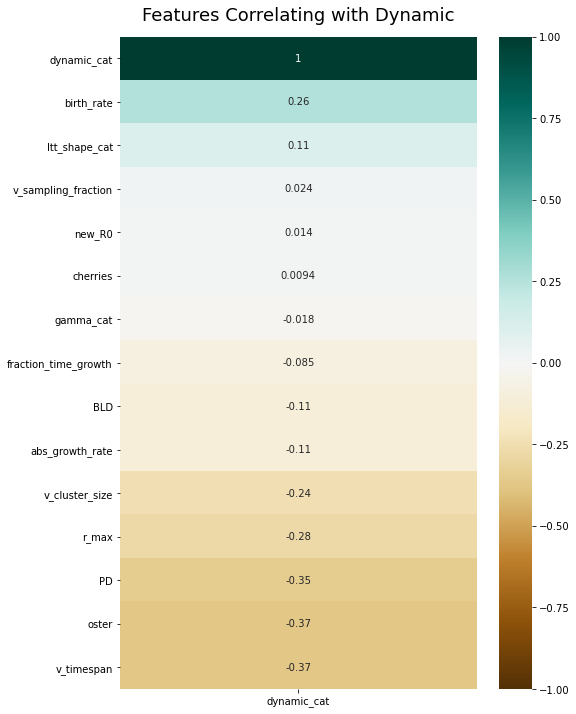

In [62]:
#check the features that are highly correlated to the output variable with Spearman
plt.figure(figsize=(8, 12))
heatmap_outputvar = sns.heatmap(aly_df.corr('spearman')[['dynamic_cat']].sort_values(by='dynamic_cat', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap_outputvar.set_title('Features Correlating with Dynamic', fontdict={'fontsize':18}, pad=16);

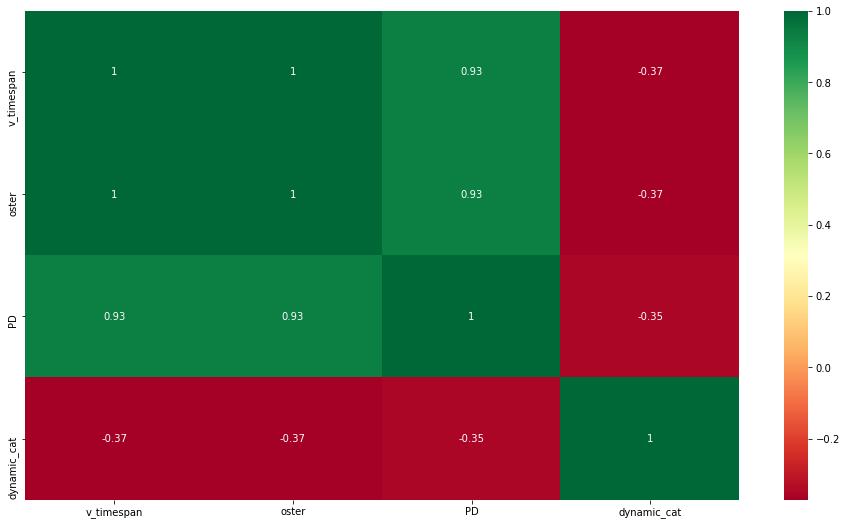

In [63]:
# most correlated features on spearman

corrmat = aly_df.corr('spearman')
top_corr_features = corrmat.index[abs(corrmat['dynamic_cat'])>0.3]
plt.figure(figsize=(16,9))
g = sns.heatmap(aly_df[top_corr_features].corr('spearman'),annot=True,cmap="RdYlGn")

#### From the above correlation plots it is evident that the features that really matter the most are:

* v_timespan
* oster
* PD

#### oster and v_timespan have a perfect positive correlation (with correlation coefficient value = 1.0)?

#### Spearm Correlation between num_feat_cols and label

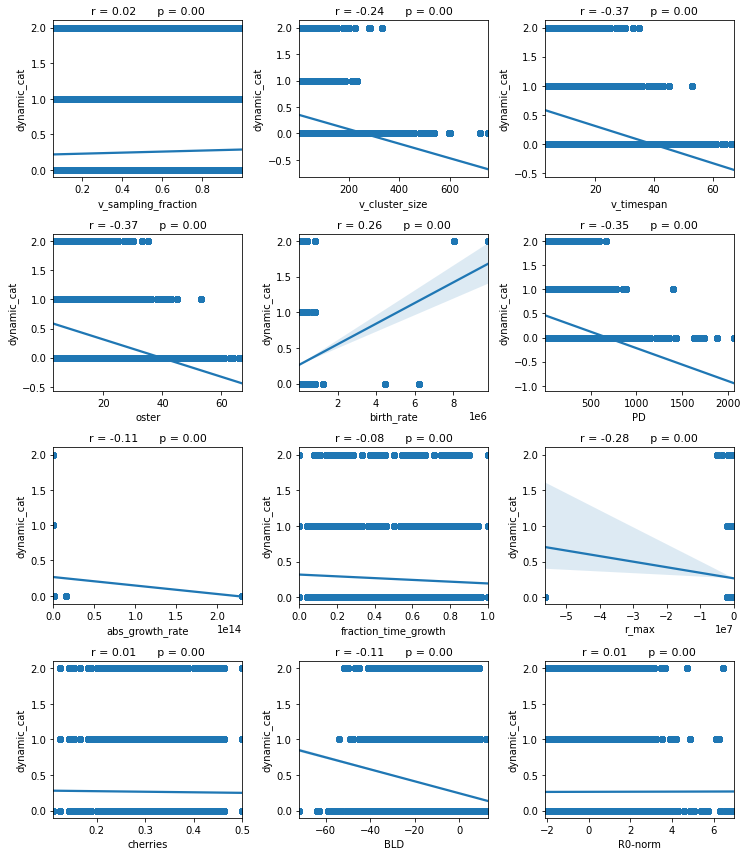

In [64]:
nr_rows = 4
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_plot_num_feats = [c for c in list(num_feat_cols) ]

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(x=aly_df[li_plot_num_feats[i]], y=aly_df['dynamic_cat'], ax = axs[r][c])
            # stp = stats.pearsonr(aly_df[num_feat_cols[i]], input_df['dynamic_cat'])
            stp = stats.spearmanr(aly_df[num_feat_cols[i]], aly_df['dynamic_cat'])
          
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()   

## Processing for Modeling

### Processing-1. One-hot encoding for the categorical feature
* ltt_shape_cat
* gamma_cat

In [64]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

cat_feat_cols = list(set(cat_feat_cols)) # ['ltt_shape_cat','gamma_cat']
print(cat_feat_cols)
cat_onehot_feat = []
org_idx = node_df.index

for cat_feat in cat_feat_cols:
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    x = enc.fit_transform(node_df[cat_feat].values.reshape(-1, 1))
    n_dims = x.shape[-1]
    columns = [f'{cat_feat}_{i}' for i in range(n_dims)]
    cat_onehot_feat += columns
    cat_df = pd.DataFrame(x, index=org_idx, columns=columns)
    node_df = pd.concat([node_df, cat_df], axis=1)

['gamma_cat', 'ltt_shape_cat']


In [65]:
node_df

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,new_R0,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3
997,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.008410,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1017.0,3.599752,"(-14.449, inf]",1,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
998,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.008410,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1018.0,3.599752,"(-14.449, inf]",1,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
999,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.008410,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1016.0,3.599752,"(-14.449, inf]",1,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1000,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.008410,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,31.0,3.599752,"(-14.449, inf]",1,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1001,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.008410,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,401.0,3.599752,"(-14.449, inf]",1,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2554189,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,1.860604,15.357890,0.333333,44.336628,convex,0.400000,-10.5,541.0,1.860604,"(-14.449, inf]",1,2,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2554190,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,1.860604,15.357890,0.333333,44.336628,convex,0.400000,-10.5,941.0,1.860604,"(-14.449, inf]",1,2,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2554191,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,1.860604,15.357890,0.333333,44.336628,convex,0.400000,-10.5,939.0,1.860604,"(-14.449, inf]",1,2,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2554192,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,1.860604,15.357890,0.333333,44.336628,convex,0.400000,-10.5,329.0,1.860604,"(-14.449, inf]",1,2,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Split the train/test sets (should put before imputing the missing values and calculating the correlation)

In [66]:
random_seed = 123
np.random.seed(random_seed)
split_dir = f'../data/{ds_name}/split_rs{random_seed}'
os.makedirs(split_dir, exist_ok=True)

from sklearn.model_selection import  train_test_split
#split the data for training and testing
train_ids, test_ids = train_test_split(tree_ids, test_size=0.2)
print(f"Train: {len(train_ids)}, Test: {len(test_ids)}")
print(test_ids[:10])

Train: 1458, Test: 365
[3087 3270  689  817 1091  949  215 2913 3580 2237]


In [67]:
train_background_df = background_df[background_df['sim'].isin(train_ids)]
test_background_df = background_df[background_df['sim'].isin(test_ids)]
train_node_df = node_df[node_df['sim'].isin(train_ids)]
test_node_df = node_df[node_df['sim'].isin(test_ids)]

print(f'Train: {train_background_df.shape[0] + train_node_df.shape[0]}')
print(f'Test: {test_background_df.shape[0] + test_node_df.shape[0]}')
train_node_df.head()

Train: 2043727
Test: 510467


,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,new_R0,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3
2521,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,468.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2522,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,814.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2523,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,433.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2524,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,343.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2525,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,803.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Processing-2. Normalize the input features:
* Use Standardization
* Use MinMax normalization to normalize data to [0, 1]

### Q7: Does normalization consider the background nodes?
A7: Not used for ML models.

array([[<AxesSubplot:title={'center':'v_sampling_fraction'}>,
        <AxesSubplot:title={'center':'v_cluster_size'}>,
        <AxesSubplot:title={'center':'v_timespan'}>],
       [<AxesSubplot:title={'center':'oster'}>,
        <AxesSubplot:title={'center':'birth_rate'}>,
        <AxesSubplot:title={'center':'PD'}>],
       [<AxesSubplot:title={'center':'abs_growth_rate'}>,
        <AxesSubplot:title={'center':'fraction_time_growth'}>,
        <AxesSubplot:title={'center':'r_max'}>],
       [<AxesSubplot:title={'center':'cherries'}>,
        <AxesSubplot:title={'center':'BLD'}>,
        <AxesSubplot:title={'center':'new_R0'}>]], dtype=object)

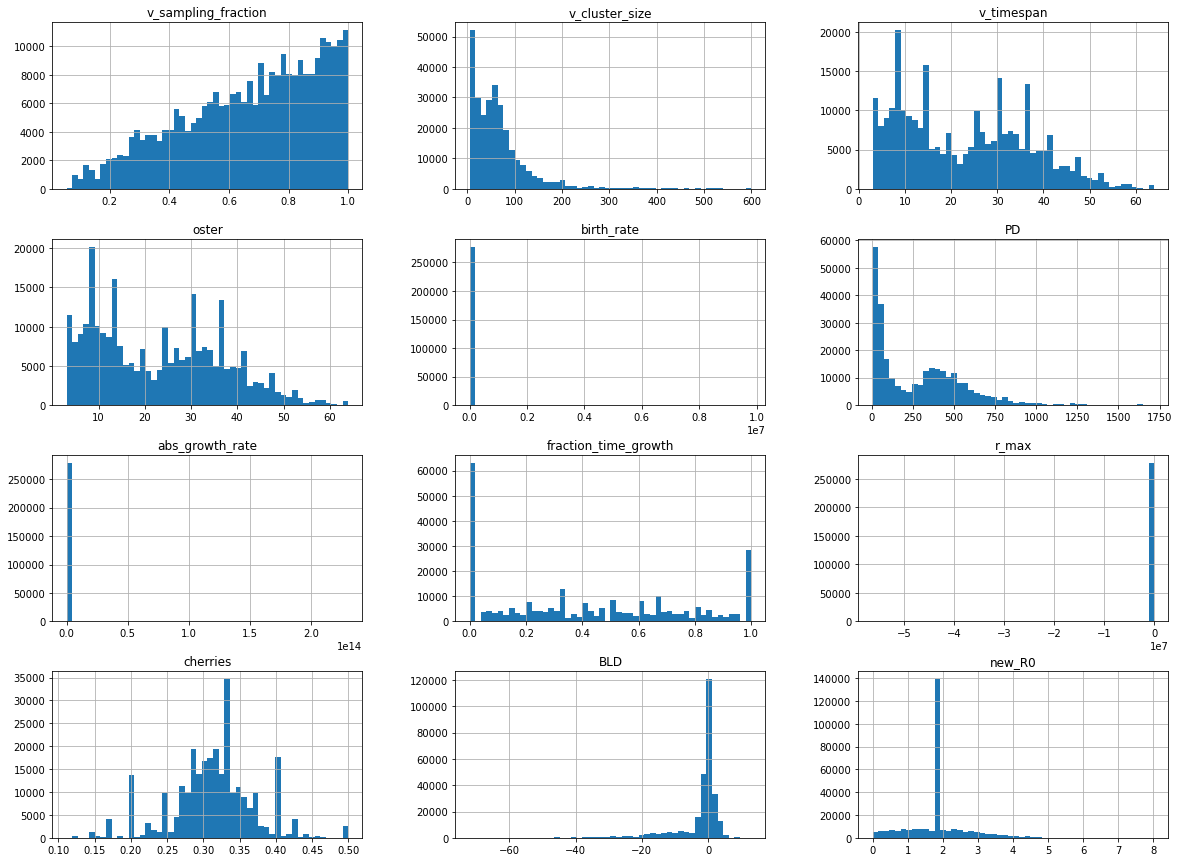

In [68]:
train_node_df[num_feat_cols].hist(bins=50,figsize=(20,15))

In [69]:
# Standardization non-category features
std_scaler = preprocessing.StandardScaler().fit(train_node_df[num_feat_cols])
norm_num_feat_cols = [f'{col_name}-norm' for col_name in num_feat_cols]
norm_train_vals = std_scaler.transform(train_node_df[num_feat_cols])
norm_train_node_df = pd.DataFrame(norm_train_vals, columns=norm_num_feat_cols, index=train_node_df.index)
train_node_df = pd.concat([train_node_df, norm_train_node_df], axis=1)

array([[<AxesSubplot:title={'center':'v_sampling_fraction-norm'}>,
        <AxesSubplot:title={'center':'v_cluster_size-norm'}>,
        <AxesSubplot:title={'center':'v_timespan-norm'}>],
       [<AxesSubplot:title={'center':'oster-norm'}>,
        <AxesSubplot:title={'center':'birth_rate-norm'}>,
        <AxesSubplot:title={'center':'PD-norm'}>],
       [<AxesSubplot:title={'center':'abs_growth_rate-norm'}>,
        <AxesSubplot:title={'center':'fraction_time_growth-norm'}>,
        <AxesSubplot:title={'center':'r_max-norm'}>],
       [<AxesSubplot:title={'center':'cherries-norm'}>,
        <AxesSubplot:title={'center':'BLD-norm'}>,
        <AxesSubplot:title={'center':'new_R0-norm'}>]], dtype=object)

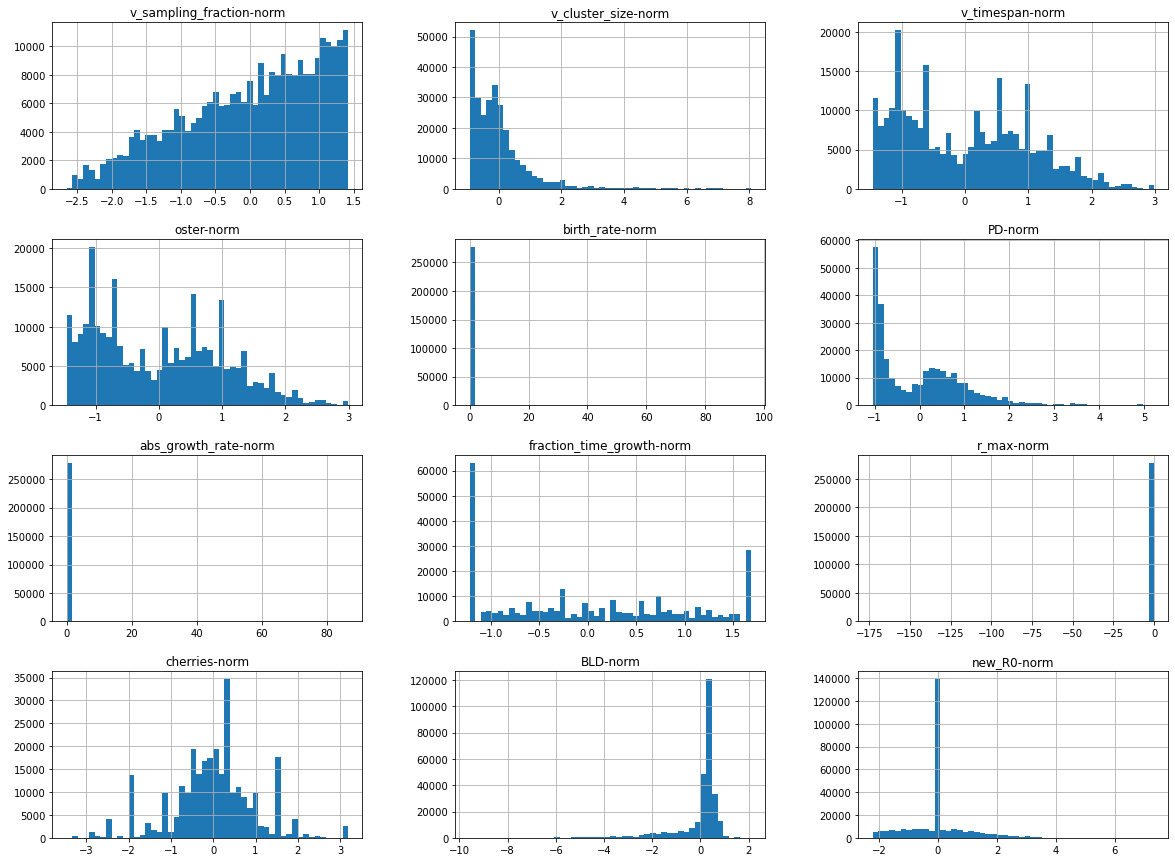

In [70]:
train_node_df[norm_num_feat_cols].hist(bins=50,figsize=(20,15))

In [71]:
print(std_scaler.mean_, std_scaler.scale_)

[ 6.70236857e-01  6.67131512e+01  2.30106868e+01  2.30385465e+01
  2.55517132e+03  2.90585847e+02  3.21234731e+10  4.19837782e-01
 -4.83017213e+03  3.13566424e-01 -2.36844829e+00  1.86770227e+00] [2.31660386e-01 6.61171254e+01 1.36989763e+01 1.36786415e+01
 1.02585046e+05 2.73162693e+02 2.66061878e+12 3.44181815e-01
 3.26120655e+05 5.83676554e-02 7.26654660e+00 8.39121978e-01]


In [72]:
norm_test_vals = std_scaler.transform(test_node_df[num_feat_cols])
norm_test_node_df = pd.DataFrame(norm_test_vals, columns=norm_num_feat_cols, index=test_node_df.index)
test_node_df = pd.concat([test_node_df, norm_test_node_df], axis=1)

array([[<AxesSubplot:title={'center':'v_sampling_fraction-norm'}>,
        <AxesSubplot:title={'center':'v_cluster_size-norm'}>,
        <AxesSubplot:title={'center':'v_timespan-norm'}>],
       [<AxesSubplot:title={'center':'oster-norm'}>,
        <AxesSubplot:title={'center':'birth_rate-norm'}>,
        <AxesSubplot:title={'center':'PD-norm'}>],
       [<AxesSubplot:title={'center':'abs_growth_rate-norm'}>,
        <AxesSubplot:title={'center':'fraction_time_growth-norm'}>,
        <AxesSubplot:title={'center':'r_max-norm'}>],
       [<AxesSubplot:title={'center':'cherries-norm'}>,
        <AxesSubplot:title={'center':'BLD-norm'}>,
        <AxesSubplot:title={'center':'new_R0-norm'}>]], dtype=object)

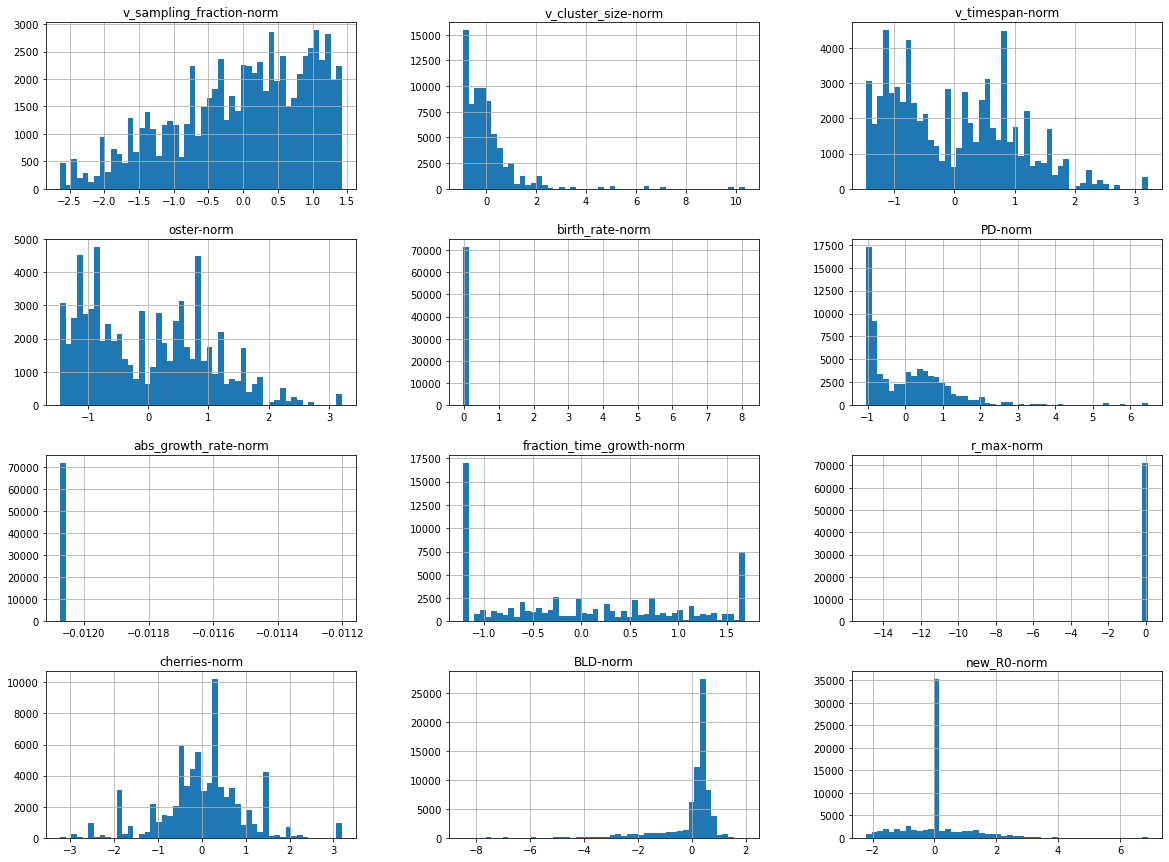

In [73]:
test_node_df[norm_num_feat_cols].hist(bins=50,figsize=(20,15))

In [74]:
# Obtain the onehot features
import re
all_cols = node_df.columns.values

onehot_cols = []
for feat_name, pattern in zip(['ltt_shape_onehot', 'R0_onehot', 'gamma_onehot'], 
                              ['ltt_shape_cat_\d*', 'R0_cat_\d*', 'gamma_cat_\d']):
    for feat_col in all_cols:
        m = re.match(pattern, feat_col)
        if m:
            feat_dict.setdefault(feat_name, []).append(m.group(0))
            
print(feat_dict)

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'gamma': {0: "(-16.218, -14.449, 'right')", 1: "(-14.449, inf, 'right')", 2: "(-6179.216, -17.185, 'right')", 3: "(-17.185, -16.218, 'right')"}, 'dynamic': {0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}, 'ltt_shape_onehot': ['ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3'], 'gamma_onehot': ['gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']}


In [75]:
print(train_node_df.shape)

(278286, 45)


In [76]:
train_node_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,new_R0,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
2521,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,468.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.922202,-0.162033,0.583205,0.582843,-0.024907,0.535996,-0.012074,0.329755,0.014907,0.452881,0.463556,-1.608266
2522,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,814.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.922202,-0.162033,0.583205,0.582843,-0.024907,0.535996,-0.012074,0.329755,0.014907,0.452881,0.463556,-1.608266
2523,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,433.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.922202,-0.162033,0.583205,0.582843,-0.024907,0.535996,-0.012074,0.329755,0.014907,0.452881,0.463556,-1.608266
2524,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,343.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.922202,-0.162033,0.583205,0.582843,-0.024907,0.535996,-0.012074,0.329755,0.014907,0.452881,0.463556,-1.608266
2525,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,803.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.922202,-0.162033,0.583205,0.582843,-0.024907,0.535996,-0.012074,0.329755,0.014907,0.452881,0.463556,-1.608266


In [77]:
train_node_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,new_R0,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
2521,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,468.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.922202,-0.162033,0.583205,0.582843,-0.024907,0.535996,-0.012074,0.329755,0.014907,0.452881,0.463556,-1.608266
2522,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,814.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.922202,-0.162033,0.583205,0.582843,-0.024907,0.535996,-0.012074,0.329755,0.014907,0.452881,0.463556,-1.608266
2523,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,433.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.922202,-0.162033,0.583205,0.582843,-0.024907,0.535996,-0.012074,0.329755,0.014907,0.452881,0.463556,-1.608266
2524,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,343.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.922202,-0.162033,0.583205,0.582843,-0.024907,0.535996,-0.012074,0.329755,0.014907,0.452881,0.463556,-1.608266
2525,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,803.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.922202,-0.162033,0.583205,0.582843,-0.024907,0.535996,-0.012074,0.329755,0.014907,0.452881,0.463556,-1.608266


### Merge the background and non-background nodes

In [78]:
# train_full_df = train_node_df.merge(train_background_df, how='inner', left_on=list(train_background_df.columns), right_on=list(train_background_df.columns), left_index=True, right_index=True)
#train_full_df = train_node_df
#print(f'Train: {train_full_df.shape}')

#test_full_df = test_node_df
#print(f'Test: {test_full_df.shape}')

train_full_df = pd.concat([train_node_df, train_background_df])
print(f'Train: {train_full_df.shape}')

test_full_df = pd.concat([test_node_df, test_background_df])
print(f'Test: {test_full_df.shape}')

Train: (2043727, 45)
Test: (510467, 45)


#### Split validation set

In [79]:
train_ids, valid_ids = train_test_split(train_ids, test_size=0.25)
print(f"Train: {len(train_ids)}, Test: {len(valid_ids)}")
print(test_ids[:10])

Train: 1093, Test: 365
[3087 3270  689  817 1091  949  215 2913 3580 2237]


In [80]:
train_full_df = train_full_df.reset_index(drop=True)
train_node_df = train_full_df[train_full_df['sim'].isin(train_ids)]
valid_node_df = train_full_df[train_full_df['sim'].isin(valid_ids)]

print(f'Train node: {train_node_df.shape[0]}')
print(f'Valid node: {valid_node_df.shape[0]}')
train_node_df.head()

Train node: 1527570
Valid node: 516157


,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,new_R0,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
321,c1,1007,A,static,0.0,0.626034,82,45.0,0.252153,45.007131,0.079161,512.0,2.583349,2.468903,0.714286,41.061247,convex,0.346154,-0.5,1046.0,2.583349,"(-14.449, inf]",1,2,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.19081,0.231209,1.605179,1.60605,-0.024907,0.810558,-0.012074,0.855501,0.014937,0.558313,0.25713,0.852852
322,c1,1007,A,static,0.0,0.626034,82,45.0,0.252153,45.007131,0.079161,512.0,2.583349,2.468903,0.714286,41.061247,convex,0.346154,-0.5,339.0,2.583349,"(-14.449, inf]",1,2,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.19081,0.231209,1.605179,1.60605,-0.024907,0.810558,-0.012074,0.855501,0.014937,0.558313,0.25713,0.852852
323,c1,1007,A,static,0.0,0.626034,82,45.0,0.252153,45.007131,0.079161,512.0,2.583349,2.468903,0.714286,41.061247,convex,0.346154,-0.5,1047.0,2.583349,"(-14.449, inf]",1,2,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.19081,0.231209,1.605179,1.60605,-0.024907,0.810558,-0.012074,0.855501,0.014937,0.558313,0.25713,0.852852
324,c1,1007,A,static,0.0,0.626034,82,45.0,0.252153,45.007131,0.079161,512.0,2.583349,2.468903,0.714286,41.061247,convex,0.346154,-0.5,252.0,2.583349,"(-14.449, inf]",1,2,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.19081,0.231209,1.605179,1.60605,-0.024907,0.810558,-0.012074,0.855501,0.014937,0.558313,0.25713,0.852852
325,c1,1007,A,static,0.0,0.626034,82,45.0,0.252153,45.007131,0.079161,512.0,2.583349,2.468903,0.714286,41.061247,convex,0.346154,-0.5,56.0,2.583349,"(-14.449, inf]",1,2,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.19081,0.231209,1.605179,1.60605,-0.024907,0.810558,-0.012074,0.855501,0.014937,0.558313,0.25713,0.852852


In [81]:
# Save the train/test to the disk
train_node_df.to_csv(f'{split_dir}/train.csv', index=False)
test_full_df.to_csv(f'{split_dir}/test.csv', index=False)
valid_node_df.to_csv(f'{split_dir}/valid.csv', index=False)

In [82]:
train_full_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,new_R0,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
0,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,468.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.922202,-0.162033,0.583205,0.582843,-0.024907,0.535996,-0.012074,0.329755,0.014907,0.452881,0.463556,-1.608266
1,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,814.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.922202,-0.162033,0.583205,0.582843,-0.024907,0.535996,-0.012074,0.329755,0.014907,0.452881,0.463556,-1.608266
2,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,433.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.922202,-0.162033,0.583205,0.582843,-0.024907,0.535996,-0.012074,0.329755,0.014907,0.452881,0.463556,-1.608266
3,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,343.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.922202,-0.162033,0.583205,0.582843,-0.024907,0.535996,-0.012074,0.329755,0.014907,0.452881,0.463556,-1.608266
4,c1,1005,A,static,0.0,0.883874,56,31.0,-1.141818,31.011043,0.087273,437.0,0.518171,3.39582,0.533333,31.301635,convex_concave,0.34,1.0,803.0,0.518171,"(-14.449, inf]",1,3,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.922202,-0.162033,0.583205,0.582843,-0.024907,0.535996,-0.012074,0.329755,0.014907,0.452881,0.463556,-1.608266


In [83]:
train_full_df.tail()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,new_R0,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
2043722,Background,99,Background,bg,0.0,0.05019,515,76.0,-16.082575,76.004632,0.03497,13191.0,0.588709,77.803408,0.594595,2424.224382,concave,0.327553,5.5,1160.0,0.588709,"(-16.218, -14.449]",0,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2043723,Background,99,Background,bg,0.0,0.05019,515,76.0,-16.082575,76.004632,0.03497,13191.0,0.588709,77.803408,0.594595,2424.224382,concave,0.327553,5.5,1158.0,0.588709,"(-16.218, -14.449]",0,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2043724,Background,99,Background,bg,0.0,0.05019,515,76.0,-16.082575,76.004632,0.03497,13191.0,0.588709,77.803408,0.594595,2424.224382,concave,0.327553,5.5,209.0,0.588709,"(-16.218, -14.449]",0,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2043725,Background,99,Background,bg,0.0,0.05019,515,76.0,-16.082575,76.004632,0.03497,13191.0,0.588709,77.803408,0.594595,2424.224382,concave,0.327553,5.5,446.0,0.588709,"(-16.218, -14.449]",0,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2043726,Background,99,Background,bg,0.0,0.05019,515,76.0,-16.082575,76.004632,0.03497,13191.0,0.588709,77.803408,0.594595,2424.224382,concave,0.327553,5.5,97.0,0.588709,"(-16.218, -14.449]",0,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finalize the feature information and save to the file

In [84]:
all_cols = test_full_df.columns
print(all_cols)

Index(['cluster_id', 'sim', 'state', 'dynamic', 'dynamic_model',
       'v_sampling_fraction', 'v_cluster_size', 'v_timespan', 'gamma', 'oster',
       'birth_rate', 'PD', 'R0', 'abs_growth_rate', 'fraction_time_growth',
       'r_max', 'ltt_shape', 'cherries', 'BLD', 'node', 'new_R0', 'gamma_bin',
       'gamma_cat', 'ltt_shape_cat', 'dynamic_cat', 'gamma_cat_0',
       'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3', 'ltt_shape_cat_0',
       'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3',
       'v_sampling_fraction-norm', 'v_cluster_size-norm', 'v_timespan-norm',
       'oster-norm', 'birth_rate-norm', 'PD-norm', 'abs_growth_rate-norm',
       'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'BLD-norm',
       'new_R0-norm'],
      dtype='object')


In [85]:
onehot_cols = feat_dict['ltt_shape_onehot'] + feat_dict['gamma_onehot']

raw_cols = num_feat_cols + cat_feat_cols
norm_onehot_cols = norm_num_feat_cols + onehot_cols
print(f'Raw cols: {raw_cols}', len(raw_cols))
print(f'Norm with onehot cols: {norm_onehot_cols}', len(norm_onehot_cols))

feat_dict['raw_feats'] = raw_cols
feat_dict['norm_onehot_feats'] = norm_onehot_cols

Raw cols: ['v_sampling_fraction', 'v_cluster_size', 'v_timespan', 'oster', 'birth_rate', 'PD', 'abs_growth_rate', 'fraction_time_growth', 'r_max', 'cherries', 'BLD', 'new_R0', 'gamma_cat', 'ltt_shape_cat'] 14
Norm with onehot cols: ['v_sampling_fraction-norm', 'v_cluster_size-norm', 'v_timespan-norm', 'oster-norm', 'birth_rate-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'BLD-norm', 'new_R0-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3'] 20


In [86]:
import json 

with open('feat_dict0427.json', 'w') as outfile:
    json.dump(feat_dict, outfile, sort_keys=True, indent=4)